In [1]:
import importlib
import os
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import pyadcirc.io as aio
import pyadcirc.utils as au
import pyadcirc.figuregen as fg
import xarray as xr
from IPython.display import Image
from taccjm import taccjm as tjm

%matplotlib widget

In [2]:
importlib.reload(tjm)

<module 'taccjm.taccjm' from '/Users/carlos/repos/taccjm/src/taccjm/taccjm.py'>

In [3]:
# Dir with this notebook resides
base_dir = Path(os.path.dirname(os.getcwd()))
data_dir = base_dir / 'notebooks' / 'data'
data_dir.mkdir(exist_ok=True)
base_dir, data_dir

(PosixPath('/Users/carlos/repos/pyadcirc'),
 PosixPath('/Users/carlos/repos/pyadcirc/notebooks/data'))

In [4]:
local_data = data_dir / 'ShinnecockInlet'
str(local_data)
os.system(f'ls -lt {local_data} | head -n 10')

total 1824
drwxr-xr-x  2 carlos  staff      64 Mar 18 00:50 fg_temp
-rw-r--r--  1 carlos  staff  542148 Mar 18 00:50 SI_mesh0001.jpg
-rw-r--r--  1 carlos  staff    7417 Mar 18 00:50 mesh.inp
-rw-r--r--  1 carlos  staff    6589 Feb 11 15:16 mesh_plot.inp
-rw-r--r--  1 carlos  staff   15338 Feb  3 13:26 fort.15
-rw-r--r--  1 carlos  staff  341496 Feb  3 13:26 fort.14
-rw-r--r--  1 carlos  staff    7774 Feb  3 13:26 bathymetry_plot.inp
-rw-r--r--  1 carlos  staff     226 Feb  3 13:26 Default.pal


0

# ADCIRC Run Example

TODO: Finish outline
Purpose of this notebook is to compress ADCIRC Output Files and Generate Common Images Related to Them

The notebook is organized as follows:

* Setup:
    * TACC Job Manager
    * ADCIRC Data
    * ADCIRC Executables
* 

## Set-Up

Here we go over the basic set-up of how this will be run.

## TACC Job Manager Set-Up

* Lets name our job manager instance `l1`. The name of the JM instance will dictate where all app, job, and other data generated by taccjm will be stored. 

* Choose system to run ADCIRC on - Here we choose ls6 - [Lonestar 6](https://portal.tacc.utexas.edu/user-guides/lonestar5)

In [5]:
jm = 'l1'
system = 'ls6'

# jm = 's1'
# system = 'stampede2'

#### Initializing TACC Job Manager

In [6]:
if jm not in tjm.list_jms():
    tjm.init_jm(jm, system)

Username:  clos21
psw:  ·········
mfa:  579174


#### Basic TACC Job Manager Commands

In [7]:
# Defaults to user home directory
files = tjm.list_files(jm, attrs=['filename'])
# tjm.list_files(jm, attrs=['filename', 'st_size'])
files

[{'filename': 'miniconda3'}, {'filename': 'lazygit'}, {'filename': 'nodejs'}]

In [8]:
[f for f in files if not f['filename'].startswith('.')]

[{'filename': 'miniconda3'}, {'filename': 'lazygit'}, {'filename': 'nodejs'}]

### ADCIRC Application

#### Local Applications

In [9]:
adcirc_app = base_dir / "apps/adcirc"
os.listdir(str(adcirc_app))

['app-tapis.json',
 '.DS_Store',
 '.ls6.ini.swp',
 'app.json',
 'stampede2.ini',
 'project.ini',
 'frontera.ini',
 'job.json',
 'ls6.ini',
 'assets']

In [10]:
os.listdir(str(adcirc_app / 'assets'))

['.run.sh.swp', '.DS_Store', 'test', 'run.sh']

#### Deploy Application

In [11]:
tjm.deploy_app(jm,local_app_dir=str(adcirc_app),proj_config_file='ls6.ini')

{'name': 'ls6_adcirc--0.0.0',
 'short_desc': 'General purpose adcirc application for ls6.',
 'long_desc': '',
 'default_node_count': 1,
 'default_processors_per_node': 10,
 'default_memory_per_node': '1',
 'default_max_run_time': '00:10:00',
 'default_queue': 'development',
 'entry_script': 'run.sh',
 'inputs': [],
 'parameters': [{'name': 'inputDirectory',
   'label': 'Input Directory',
   'desc': 'The directory containing ADCIRC input files.'},
  {'name': 'execDirectory',
   'label': 'Executables Directory',
   'desc': 'The directory containing ADCIRC executables to use.'},
  {'name': 'writeProcesses',
   'label': 'Number of Write Processes',
   'desc': 'Number of processes to dedicate to writing output data.'}],
 'outputs': [{'name': 'Outputs',
   'label': 'Output Directory',
   'desc': 'Directory containing output to archive.'}]}

In [12]:
tjm.list_apps(jm)

['ls6_adcirc--0.0.0', 'pylauncher--0.0.0']

### ADCIRC Data 

* Publicly accessible data is available for users to access at `/work/06307/clos21/pub/adcirc`.

* Directories `inputs` and `execs` contain input data/configuration files for ADCIRC runs and executables to run them.

* README docs within directories contain more info on how executables/inputs.

In [11]:
# Pub dir paths on TACC. Should be accessible from all systems
pub_dir = Path('/work2/06307/clos21/pub')
adc_inputs = pub_dir / 'adcirc' / 'inputs'
adc_execs = pub_dir / 'adcirc' / 'execs'

tjm.list_files(jm, adc_inputs), tjm.list_files(jm, adc_execs)

([{'filename': 'Alaska'},
  {'filename': 'Texas'},
  {'filename': 'ShinnecockInlet'}],
 [{'filename': 'ls6'}, {'filename': 'stampede2'}])

#### SI Inlet Data

In [20]:
# Pub dir paths on TACC. Should be accessible from all systems
si_dir = adc_inputs / 'ShinnecockInlet/mesh/def'

tjm._print_res(tjm.list_files(jm, si_dir, attrs=['st_mode']), fields=['filename', 'st_mode'])

+---------------------+---------+
|       filename      | st_mode |
+---------------------+---------+
|    mesh_plot.inp    |  33188  |
|     Default.pal     |  33188  |
|       fort.15       |  33188  |
| bathymetry_plot.inp |  33188  |
|       fort.14       |  33188  |
+---------------------+---------+


Lets look at the README file available for the ShinnecockInlet Area

In [21]:
si_path = adc_inputs / 'ShinnecockInlet'

print(tjm.read(jm, si_path / 'README.rst'))

###########################
Shinnecock Inlet Base Grid
###########################

[Shinnecock Inlet](https://adcirc.org/home/documentation/example-problems/shinnecock-inlet-ny-with-tidal-forcing-example/) example.

Mesh Files - mesh/*

Description of mesh file directories for particular area.

-------
Default
-------

Only one mesh contained currently here, which is the default mesh used containing a grid (fort.14) and a control file (fort.15) with just tidal forcing confgured with tidal forcing constituents derived from [TPX09.1](https://www.tpxo.net/home) configured via [OceanMesh2D](https://github.com/CHLNDDEV/OceanMesh2D).

The default control file (fort.15) included is set up to run with a timestep of 6 seconds for 20 days.

Furthere control file (fort.15) has the following recording stations set up (looking northwest for all):

 1. Back Right Bay  : -72.45 W, 40.870 E 
 2. Left of Inlet   : -72.50 W, 40.825 E 
 3. Right of Inlet  : -72.30 W, 40.800 E 

Output data (water elevat

In [22]:
# Default SI Inlet Mesh - Tides only
si_mesh_path = adc_inputs / 'ShinnecockInlet/mesh/def'

tjm.list_files(jm, si_mesh_path)

[{'filename': 'mesh_plot.inp'},
 {'filename': 'Default.pal'},
 {'filename': 'fort.15'},
 {'filename': 'bathymetry_plot.inp'},
 {'filename': 'fort.14'}]

#### Download locally

In [23]:
tjm.download(jm, remote_path=str(si_mesh_path), local_path=str(data_dir))
os.system(f'ls -lt {data_dir} | head -n 10')

total 0
drwxr-xr-x   7 carlos  staff  224 May 12 09:47 def
drwxr-xr-x@ 18 carlos  staff  576 Mar 19 14:17 ak_lw_mesh
drwxr-xr-x  12 carlos  staff  384 Mar 18 00:50 ShinnecockInlet
drwxr-xr-x  19 carlos  staff  608 Mar 17 23:55 ak_test
drwxr-xr-x   7 carlos  staff  224 Mar 16 17:49 ncar


0

### ADCIRC Executables


In [25]:
tjm.list_files(jm, adc_execs)

[{'filename': 'ls6'}, {'filename': 'stampede2'}]

Choose appropriate version:

In [26]:
tjm.list_files(jm, adc_execs / 'ls6')

[{'filename': 'v55_nodal_beta'}, {'filename': 'v55.01'}]

Verify executables exist:

In [27]:
# Lonestar6 v55.01 execs
ls6_v55_path = adc_execs / 'ls6' / 'v55.01'
tjm.list_files(jm, ls6_v55_path)

[{'filename': 'padcirc'}, {'filename': 'adcprep'}]

### Building ADCIRC Versions

Requires: Github credentials set-up on remote system.

Access to [adcirc-cg](https://github.com/cdelcastillo21/adcirc-cg?organization=cdelcastillo21&organization=cdelcastillo21) repo.

Will be using TACC Job Manager to deploy and run an ADCIRC Compile script


TODO: Fix bugs in run_script with args.
Improve compile script to allow:
    Specifying destination directory
    Specifying output directory

In [13]:
tjm.list_scripts(jm)

[]

In [15]:
tjm.deploy_script(jm, script_name=str(base_dir / 'scripts/adcirc_compile.sh'))

In [17]:
# Fix bug: https://github.com/cdelcastillo21/taccjm/issues/10
# For now just ran this command on ls6 manually to build v55.01 and v55_nodal_beta branches
tjm.run_script(jm, 'adcirc_compile', args=["v55.01", "https://github.com/cdelcastillo21/adcirc-cg.git", "1"])

run_script error


TACCJMError: Command error : Non-zero return code.
clos21@stampede2.tacc.utexas.edu$ /scratch/06307/clos21/s1/scripts/adcirc_compile v55.01 https://github.com/cdelcastillo21/adcirc-cg.git 1
rc     : 1
stdout : /scratch/06307/clos21/s1/scripts/adcirc_compile: line 40: log: command not found
Switched to a new branch 'v55.01-branch'
cp: cannot stat ‘padcswan’: No such file or directory
stderr : Fetching origin
Already up to date.
-- The C compiler identification is Intel 18.0.2.20180210
-- The CXX compiler identification is Intel 18.0.2.20180210
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /opt/intel/compilers_and_libraries_2018.2.199/linux/bin/intel64/icc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /opt/intel/compilers_and_libraries_2018.2.199/linux/bin/intel64/icpc - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- The Fortran compiler identification is Intel 18.0.2.20180210
-- Detecting Fortran compiler ABI info
-- Detecting Fortran compiler ABI info - done
-- Check for working Fortran compiler: /opt/intel/compilers_and_libraries_2018.2.199/linux/bin/intel64/ifort - skipped
-- Checking whether /opt/intel/compilers_and_libraries_2018.2.199/linux/bin/intel64/ifort supports Fortran 90
-- Checking whether /opt/intel/compilers_and_libraries_2018.2.199/linux/bin/intel64/ifort supports Fortran 90 - yes
-- Found MPI_C: /opt/intel/compilers_and_libraries_2018.2.199/linux/mpi/intel64/lib/release_mt/libmpi.so (found version "3.1") 
-- Found MPI_CXX: /opt/intel/compilers_and_libraries_2018.2.199/linux/mpi/intel64/lib/libmpicxx.so (found version "3.1") 
-- Found MPI_Fortran: /opt/intel/compilers_and_libraries_2018.2.199/linux/mpi/intel64/lib/libmpifort.so (found version "3.1") 
-- Found MPI: TRUE (found version "3.1")  
-- Unlimited stack size detected. No heap array flag added.
-- Found NetCDF: /opt/apps/intel18/netcdf/4.6.2/x86_64/lib/libnetcdff.so;/opt/apps/intel18/netcdf/4.6.2/x86_64/lib/libnetcdf.so  
-- Configuring done
-- Generating done
-- Build files have been written to: /work2/06307/clos21/stampede2/adcirc_execs/repo/build

## Running ADCIRC - SI Base Case

Here we go over the details of running ADCIRC 

### ADCIRC App Config

Basic ADCIRC App config:

In [28]:
tjm.list_apps(jm)

['ls6_adcirc--0.0.0', 'pylauncher--0.0.0']

In [82]:
tjm.get_app(jm, 'ls6_adcirc--0.0.0')

{'name': 'ls6_adcirc--0.0.0',
 'short_desc': 'General purpose adcirc application for ls6.',
 'long_desc': '',
 'default_node_count': 1,
 'default_processors_per_node': 10,
 'default_memory_per_node': '1',
 'default_max_run_time': '00:10:00',
 'default_queue': 'development',
 'entry_script': 'run.sh',
 'inputs': [],
 'parameters': [{'name': 'inputDirectory',
   'label': 'Input Directory',
   'desc': 'The directory containing ADCIRC input files.'},
  {'name': 'execDirectory',
   'label': 'Executables Directory',
   'desc': 'The directory containing ADCIRC executables to use.'},
  {'name': 'writeProcesses',
   'label': 'Number of Write Processes',
   'desc': 'Number of processes to dedicate to writing output data.'}],
 'outputs': [{'name': 'Outputs',
   'label': 'Output Directory',
   'desc': 'Directory containing output to archive.'}]}

### Configure job 

Configure inputs

In [91]:
# Set execs_dir for future cells to use
in_dir = si_mesh_path
execs_dir = ls6_v55_path
write_proc = 0

In [101]:
from pprint import pprint as pp
job_config = {'name': "test-job",
               'app':'ls6_adcirc--0.0.0',
               'desc':"Testing ADCIRC on LS6",
               'queue':"development",
               'node_count':1,
               'processors_per_node':4,
               'memory_per_node':1,
               'max_run_time':"00:00:10"}
job_config['inputs'] = {}
job_config['parameters'] = {'inputDirectory': f"{in_dir}",
                            'execDirectory' : f"{execs_dir}",
                            'writeProcesses': write_proc}
pp(job_config)

{'app': 'ls6_adcirc--0.0.0',
 'desc': 'Testing ADCIRC on LS6',
 'inputs': {},
 'max_run_time': '00:00:10',
 'memory_per_node': 1,
 'name': 'test-job',
 'node_count': 1,
 'parameters': {'execDirectory': '/work2/06307/clos21/pub/adcirc/execs/ls6/v55.01',
                'inputDirectory': '/work2/06307/clos21/pub/adcirc/inputs/ShinnecockInlet/mesh/def',
                'writeProcesses': 0},
 'processors_per_node': 4,
 'queue': 'development'}


### Deploy Job 


In [102]:
importlib.reload(tjm)

<module 'taccjm.taccjm' from '/Users/carlos/repos/taccjm/src/taccjm/taccjm.py'>

In [183]:
deployed = tjm.deploy_job(jm, job_config=job_config)
pp(deployed)

{'app': 'ls6_adcirc--0.0.0',
 'desc': 'Testing ADCIRC on LS6',
 'entry_script': 'run.sh',
 'inputs': {},
 'job_dir': '/scratch/06307/clos21/l1/jobs/test-job_20220203_180159',
 'job_id': 'test-job_20220203_180159',
 'max_run_time': '00:00:10',
 'memory_per_node': 1,
 'name': 'test-job',
 'node_count': 1,
 'parameters': {'execDirectory': '/work2/06307/clos21/pub/adcirc/execs/ls6/v55.01',
                'inputDirectory': '/work2/06307/clos21/pub/adcirc/inputs/ShinnecockInlet/mesh/def',
                'writeProcesses': 0},
 'processors_per_node': 4,
 'queue': 'development'}


In [184]:
tjm.list_files(jm, deployed['job_dir'])

['submit_script.sh', 'app.json', 'run.sh', 'test', 'job.json']

In [105]:
# TODO: fix bug here - see https://github.com/cdelcastillo21/taccjm/issues/9
tjm.list_job_files(jm, deployed['job_id'])

list_job_files error


TACCJMError: <Response [500]>Unable to parse json errors. Raw content:A server error occurred.  Please contact the administrator.

### Running Job

Now we can submit the job to run on the execution queue

In [185]:
submitted = tjm.submit_job(jm, deployed['job_id'])

In [186]:
pp(submitted)

{'app': 'ls6_adcirc--0.0.0',
 'desc': 'Testing ADCIRC on LS6',
 'entry_script': 'run.sh',
 'inputs': {},
 'job_dir': '/scratch/06307/clos21/l1/jobs/test-job_20220203_180159',
 'job_id': 'test-job_20220203_180159',
 'max_run_time': '00:00:10',
 'memory_per_node': 1,
 'name': 'test-job',
 'node_count': 1,
 'parameters': {'execDirectory': '/work2/06307/clos21/pub/adcirc/execs/ls6/v55.01',
                'inputDirectory': '/work2/06307/clos21/pub/adcirc/inputs/ShinnecockInlet/mesh/def',
                'writeProcesses': 0},
 'processors_per_node': 4,
 'queue': 'development',
 'slurm_id': '50473'}


### Checking job status

In [187]:
tjm.get_queue(jm)

[{'job_id': '50473',
  'job_name': 'test-job_2',
  'username': 'clos21',
  'state': 'Running',
  'nodes': '1',
  'remaining': '1',
  'start_time': '0:00:57'}]

We can also look at job files 

For example for adcirc runs we can look for an adcirc.log file (provided the appropriate setting is set in fort.15 file to output to log file)

In [199]:
job_files = tjm.list_files(jm, submitted['job_dir'])
job_files.sort()
job_files

['Default.pal',
 'PE0000',
 'PE0001',
 'PE0002',
 'PE0003',
 'adcirc.log',
 'adcprep',
 'app.json',
 'bathymetry_plot.inp',
 'fort.14',
 'fort.15',
 'fort.16',
 'fort.61.nc',
 'fort.62.nc',
 'fort.63.nc',
 'fort.64.nc',
 'fort.80',
 'job.json',
 'maxele.63.nc',
 'maxvel.63.nc',
 'mesh_plot.inp',
 'metis_graph.txt',
 'output.eo.txt',
 'padcirc',
 'partmesh.txt',
 'run.sh',
 'submit_script.sh',
 'test',
 'test-job_20220203_180159.e50473',
 'test-job_20220203_180159.o50473']

And we can peak at the end of the file to see how long the run is going

In [195]:
print(tjm.peak_file(jm, str(Path(submitted['job_dir']) / 'adcirc.log'), tail=2))


 TIME STEP =  107000  37.15% COMPLETE     ITERATIONS =   17     TIME =  0.64200000E+06
  ELMAX = -1.0169E-001 AT NODE      836  SPEEDMAX =  1.3272E-001 AT NODE      799  ON MYPROC =    0



In [194]:
print(tjm.peak_file(jm,
                    str(Path(submitted['job_dir']) / f"{submitted['job_id']}.e{submitted['slurm_id']}"), tail=2))

+ ibrun -np 4 ./padcirc -W 0
slurmstepd: error: *** JOB 50473 ON c302-005 CANCELLED AT 2022-02-03T18:03:25 DUE TO TIME LIMIT ***



# ADCIRC Output Files

Here we'll download and analyze some outputs

## F61 - Water Elevation at Recording Stations

See [documentation](https://adcirc.org/home/documentation/users-manual-v51/output-file-descriptions/elevation-time-series-at-specified-elevation-recording-stations-fort-61) for more info on this file.

In [201]:
path = tjm.download_job_file(jm, submitted['job_id'], 'fort.61.nc', dest_dir=data_dir)

In [133]:
f61 = xr.open_dataset(path)
f61

<xarray.Dataset>
Dimensions:       (time: 398, station: 3)
Coordinates:
  * time          (time) datetime64[ns] 2008-09-04T15:30:00 ... 2008-09-12T22...
Dimensions without coordinates: station
Data variables:
    station_name  (station) |S50 ...
    x             (station) float64 ...
    y             (station) float64 ...
    zeta          (time, station) float64 ...
Attributes: (12/50)
    _FillValue:         -99999.0
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            v55.01-10-g08f4100
    grid_type:          Triangular
    description:        Shinnecock Inlet V20051108               ! UPTO 32 CH...
    ...                 ...
    sfea0:              40.66
    cf:                 0.0025
    eslm:               5.0
    cori:               0.0001
    ntif:               5
    nbfr:               5

In [170]:
str(f61['station_name'].values[0].decode('utf-8'))[0:15]

'Back right bay '

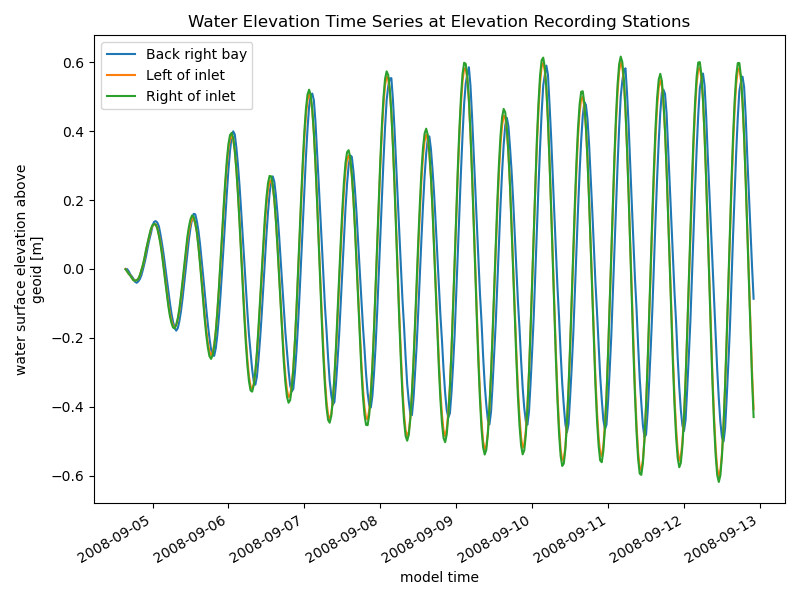

In [174]:
fig, ax =plt.subplots(1, 1, figsize=(8,6))
for i in range(3):
    name = str(f61['station_name'].values[i].decode('utf-8'))[0:14]
    f61.isel(station=i)['zeta'].plot(ax=ax, label=name)
ax.legend()
ax.set_title('Water Elevation Time Series at Elevation Recording Stations')
fig.tight_layout()

## F62 - Depth-averaged Velocity Time Series at Recording Stations

This is the depth-averaged velocity as computed by ADCIRC at nodes we set to record at.

See [documentation](https://adcirc.org/home/documentation/users-manual-v51/output-file-descriptions/depth-averaged-velocity-time-series-at-specified-velocity-recording-stations-fort-62) for more info on this file.

In [180]:
f62_path = tjm.download_job_file(jm, submitted['job_id'], 'fort.62.nc', dest_dir=data_dir)

In [181]:
f62 = xr.open_dataset(f62_path)
f62

<xarray.Dataset>
Dimensions:       (time: 398, station: 3)
Coordinates:
  * time          (time) datetime64[ns] 2008-09-04T15:30:00 ... 2008-09-12T22...
Dimensions without coordinates: station
Data variables:
    station_name  (station) |S50 ...
    x             (station) float64 ...
    y             (station) float64 ...
    u-vel         (time, station) float64 ...
    v-vel         (time, station) float64 ...
Attributes: (12/50)
    _FillValue:         -99999.0
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            v55.01-10-g08f4100
    grid_type:          Triangular
    description:        Shinnecock Inlet V20051108               ! UPTO 32 CH...
    ...                 ...
    sfea0:              40.66
    cf:                 0.0025
    eslm:               5.0
    cori:               0.0001
    ntif:               5
    nbfr:               5

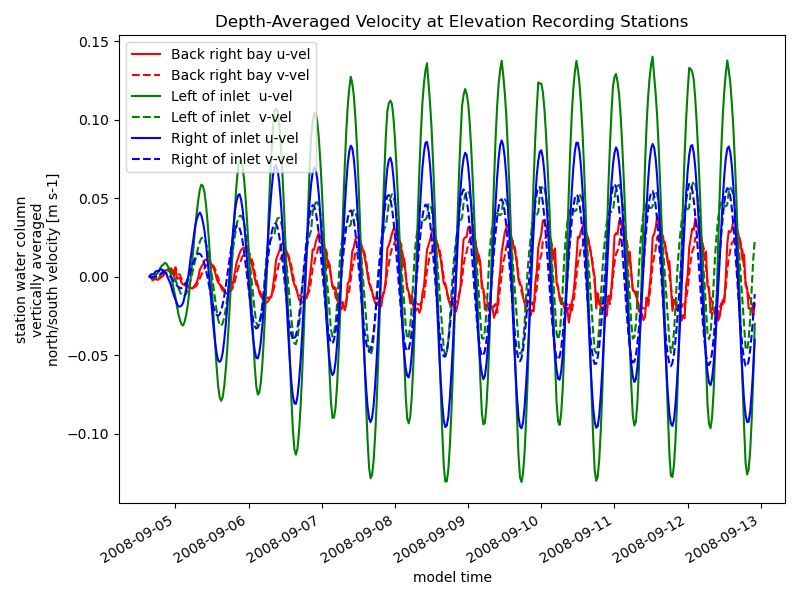

In [182]:
fig, ax =plt.subplots(1, 1, figsize=(8,6))
cs = ['r', 'g', 'b']
for i in range(3):
    name = str(f62['station_name'].values[i].decode('utf-8'))[0:14]
    f62.isel(station=i)['u-vel'].plot(ax=ax, color=cs[i], label=name + ' u-vel')
    f62.isel(station=i)['v-vel'].plot(ax=ax, color=cs[i], label=name + ' v-vel', linestyle='--')
ax.legend()
ax.set_title('Depth-Averaged Velocity at Elevation Recording Stations')
fig.tight_layout()

## F63 - Water Elevation at All Nodes

See [documentation](https://adcirc.org/home/documentation/users-manual-v51/output-file-descriptions/elevation-time-series-at-all-nodes-in-the-model-grid-fort-63) for more info on this file.

### Using Python

TODO: Bug here with importing datashade from holoviews. 

In [202]:
path = tjm.download_job_file(jm, submitted['job_id'], 'fort.63.nc', dest_dir=data_dir)

We have to clean up the files by removing a couple of duplicate variables (that are set as both coordinates and variables, violating xarray requirements). We can do that with:

```
ncks -O -x -v neta,nbdv,nvel,nbvv fort.63.nc clean.f63.nc
```

In [206]:
clean_file = Path(path).parents[0] / 'clean.f63.nc'
f63 = xr.open_dataset(clean_file)
f63

<xarray.Dataset>
Dimensions:      (mesh: 1, node: 3070, nele: 5780, nvertex: 3, nbou: 1,
                  nope: 1, time: 359)
Coordinates:
  * time         (time) datetime64[ns] 2008-09-04T15:30:00 ... 2008-09-12T02:...
    x            (node) float64 ...
    y            (node) float64 ...
Dimensions without coordinates: mesh, node, nele, nvertex, nbou, nope
Data variables:
    adcirc_mesh  (mesh) int32 ...
    depth        (node) float64 ...
    element      (nele, nvertex) int32 ...
    ibtype       (nbou) int32 ...
    ibtypee      (nope) int32 ...
    max_nvdll    int32 ...
    max_nvell    int32 ...
    nvdll        (nope) int32 ...
    nvell        (nbou) int32 ...
    zeta         (time, node) float64 ...
Attributes: (12/50)
    _FillValue:         -99999.0
    model:              ADCIRC
    version:            v55.01-10-g08f4100
    grid_type:          Triangular
    description:        Shinnecock Inlet V20051108               ! UPTO 32 CH...
    agrid:              Shinnecock Inlet Coarse Grid
    ...                 ...
    cf:                 0.0025
    eslm:               5.0
    cori:               0.0001
    ntif:               5
    nbfr:               5
    NCO:                netCDF Operators version 5.0.6 (Homepage = http://nco...